In [308]:
import deeplake
import matplotlib.pyplot as plt
import os
import cv2, numpy, vptree, PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms, models
import time
import tensorflow as tf
import faiss
import pickle

In [281]:
def plot_image(img):
    if (len(img.shape) == 2):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [282]:
def plot_many(images):
    num_images = len(images)
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    # Plot each image
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
    
    # Show the plot
    plt.show()


In [283]:
# turns image into the shape (x, x, 3)
def reorient_channels(img):
    if len(img.shape) == 2:
        return img
    if len(img.shape) != 3:
        raise Exception("Image does not have 2 or 3 channels")

    # color_channel = img.shape.index(3)
    channels = [-1, -1, -1]
    shape = img.shape
    for i in range(3):
        if shape[i] == 3:
            channels[2] = i
        else:
            idx = channels.index(-1)
            channels[idx] = i
            
    # print(channels)
    correct = tf.transpose(img, [channels[0], channels[1], channels[2]])
    return correct

In [284]:
def canny_edge_detection(image, val):
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Convert to np.uint8
    blurred_image_uint8 = np.uint8(blurred_image * 255)
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image_uint8, val, val * 2)
    
    return edges

In [285]:
# def canny(img, thresh1, thresh2):
#     img_uint8 = (img.numpy() * 255).astype(np.uint8)
#     return cv2.Canny(img_uint8, thresh1, thresh2)

In [286]:
edges = torch.load('edges.pt')
og = torch.load('og.pt')

In [288]:
canny_edges = []

for i in range(len(edges)):
    val = 50
    scaled = (edges[i].numpy() * 255).astype('uint8')
    canny = canny_edge_detection(reorient_channels(og[i]).numpy(), 100)
    canny_edges.append(canny)
    # plot_many([edges[i], cv2.Canny(scaled, val, 2 * val), reorient_channels(og[i]), canny_edge_detection(reorient_channels(og[i]).numpy(), 100), canny])

In [289]:
print(len(canny_edges), type(canny_edges), type(canny_edges[0]))

320 <class 'list'> <class 'numpy.ndarray'>


In [311]:
descriptor_list = []

contour_list = []

for i in range(len(canny_edges)):
    contours, hierarchy = cv2.findContours(canny_edges[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        if cv2.contourArea(contour) > 35 and cv2.arcLength(contour,-1) > 100:
            contour_list.append(contour)
        
    for idx,item in enumerate(contour_list):
        points_tensor = torch.from_numpy(contour_list[idx][:,0,:])
        centroid = points_tensor.float().mean(dim=0)
        centered_points = (points_tensor - centroid).to(torch.float64)
        cnt1 = centered_points.numpy()
        scale = np.max(np.abs(cnt1))
        # print(scale)
        cnt1 /= scale
        dft = np.fft.fft(cnt1[:, 0] + 1j * cnt1[:, 1])
        descriptors = dft[:10]
        real_vectors = np.concatenate((np.real(descriptors), np.imag(descriptors)), axis=0)
        descriptor_list.append(real_vectors)

In [300]:
a = torch.tensor(np.array(descriptor_list))
a.shape

20

In [292]:
# for i, contour in enumerate(contours):
#     contour_shape = contours[0].shape
#     # 
#     # Create a zero array with the same shape as contours[0], plus an additional dimension
#     contour_image = np.zeros((1,) + contour_shape, dtype=np.uint8)

#     # Draw the current contour on the blank image
#     cv2.drawContours(contour_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

#     # Save the contour image to a separate file
#     contour_filename = os.path.join(output_dir, f'contour_{i}.jpg')
#     cv2.imwrite(contour_filename, contour_image)


In [294]:
# tensor[0].shape

In [295]:
# source_img = np.zeros((128, 128, 3), dtype=np.uint8)

# # cv2.drawContours(source_img, contour_list, 3, (0,255,0), 1)

# for idx, item in enumerate(contours):
#     source_img = np.zeros((128, 128, 3), dtype=np.uint8)
#     filename = os.path.join(output_dir, f"array_{idx}.jpg")
#     cv2.imwrite(filename, cv2.drawContours(source_img, contours, idx, (0,255,0), 1))

In [297]:

# # Create an empty tensor to store the binary masks
# tensor_list = []

# for idx, item in enumerate(contours):
#     # Create a tensor of zeros with shape (128, 128)
#     tensor = torch.zeros(128, 128)
    
#     # Set the specified indices to 1
#     for point in item:
#         y, x = point[0]  # Extract y and x coordinates
#         tensor[x, y] = 1  # Set the value at the specified indices to 1
    
#     # Append the tensor to the tensor list
#     tensor_list.append(tensor)

# # Stack the tensors along a new dimension to create the ultimate tensor
# ultimate_tensor = torch.stack(tensor_list)


In [306]:
nlist = 15
k = 4
d = a.shape[1]
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(a)
assert index.is_trained

index.add(a)                     # add may be a bit slower as well
# D, I = index.search(xq, k)     # actual search
# print(I[-5:])                  # neighbors of the 5 last queries
# index.nprobe = 10              # default nprobe is 1, try a few more
# D, I = index.search(xq, k)
# print(I[-5:])                  # neighbors of the 5 last queries


In [309]:
index_bytes = faiss.serialize_index(index)
with open('index.pickle', 'wb') as f:
    pickle.dump(index_bytes, f)

In [313]:
# contour_list

In [314]:
len(contour_list)

684

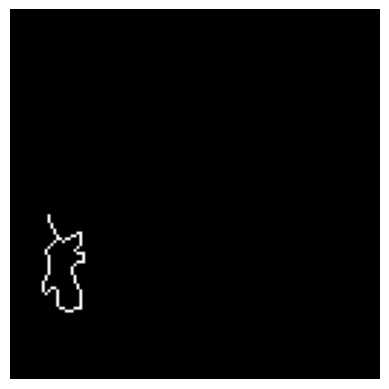

In [327]:
image = np.zeros((128, 128), dtype=np.uint8)
for i in contour_list[100]:
    coord = i[0]
    image[coord[0], coord[1]] = 1
    
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()